In [ ]:
import torch

In [ ]:
torch.__version__

In [ ]:
!nvcc --version

In [ ]:
import torchvision

In [ ]:
torchvision.__version__

In [ ]:
!pip install -f https://download.pytorch.org/whl/torch_stable.html torch===1.10.0+cu111 torchvision===0.11.1+cu111

In [ ]:
#!pip install -f https://download.pytorch.org/whl/torch_stable.html torch===1.10.0 


In [ ]:
#!wget https://mirror.sjtu.edu.cn/pytorch-wheels/cu111/torch-1.10.0+cu111-cp36-cp36m-linux_x86_64.whl
    

In [ ]:
#!pip install  https://mirror.sjtu.edu.cn/pytorch-wheels/cu111/torch-1.10.0+cu111-cp36-cp36m-linux_x86_64.whl

In [ ]:
#!pip install  https://mirror.sjtu.edu.cn/pytorch-wheels/cu111/torch-1.10.0+cu111-cp37-cp37m-linux_x86_64.whl

In [ ]:
#!pip install  https://mirror.sjtu.edu.cn/pytorch-wheels/cu111/torch-1.10.0+cu111-cp38-cp38-linux_x86_64.whl

In [ ]:
#!pip install  https://mirror.sjtu.edu.cn/pytorch-wheels/cu111/torch-1.10.0+cu111-cp39-cp39-linux_x86_64.whl

In [ ]:
#!conda install pytorch torchvision torchaudio cudatoolkit=11.1 -c pytorch

In [ ]:
assert "1.10.0" in torch.__version__

In [ ]:
torch.__version__

In [ ]:
# Install PHOSA
import torch
#assert "1.4.0" in torch.__version__
!git clone https://github.com/facebookresearch/phosa.git phosa_repo
!mv phosa_repo/* .
!pip install -r requirements.txt

In [ ]:
!mkdir -p external 
!git clone https://github.com/JiangWenPL/multiperson.git external/multiperson 
!pip install external/multiperson/neural_renderer 

In [ ]:
!pip install pyyaml==5.1
!mkdir -p external
# clone the repo in order to access pre-defined configs in PointRend project
!git clone --branch v0.6 https://github.com/facebookresearch/detectron2.git external/detectron2
# install detectron2 from source
!pip install -e external/detectron2
# See https://detectron2.readthedocs.io/tutorials/install.html for other installation options‏

In [ ]:
# Install bodymocap
!mkdir -p external
!git clone https://github.com/facebookresearch/frankmocap.git external/frankmocap
!sh external/frankmocap/scripts/download_data_body_module.sh
# We are hosting the SMPL model here for convenience. Please accept the license
# agreement on the SMPL website: https://smpl.is.tue.mpg.de
!wget -P extra_data/smpl https://jasonyzhang.com/phosa_data/basicModel_neutral_lbs_10_207_0_v1.0.0.pkl

In [ ]:
!pip install external/multiperson/neural_renderer

In [ ]:
!pip install -e external/detectron2

In [ ]:
!pip install pyyaml==5.1

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import torch
from PIL import Image

from phosa.constants import (
   
    DEFAULT_LOSS_WEIGHTS,
    IMAGE_SIZE,

)

import neural_renderer as nr
from detectron2.data import MetadataCatalog
from detectron2.structures import Boxes, BitMasks
from detectron2.utils.visualizer import Visualizer as PointRendVisualizer

from phosa.bodymocap import (
    get_bodymocap_predictor,
    process_mocap_predictions,
    visualize_orthographic,
)
from phosa.global_opt import optimize_human_object, visualize_human_object
from phosa.pointrend import get_pointrend_predictor
from phosa.pose_optimization import find_optimal_poses
from phosa.utils import bbox_xy_to_wh, center_vertices

prop = torch.cuda.get_device_properties(0)
print(f"GPU: {prop.name}")
print(f"VRAM: {prop.total_memory / 1e9:.1f}GB")
print(f"CC: {prop.major}.{prop.minor}")

GPU: Tesla K80
VRAM: 12.0GB
CC: 3.7


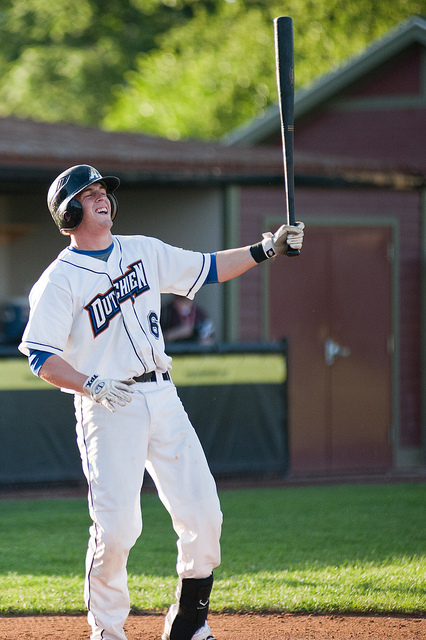

In [2]:
!wget http://images.cocodataset.org/test2017/000000255040.jpg -q -O input12.jpg
image_pil = Image.open("input12.jpg")
image = np.array(image_pil)
image_pil

(426, 640)


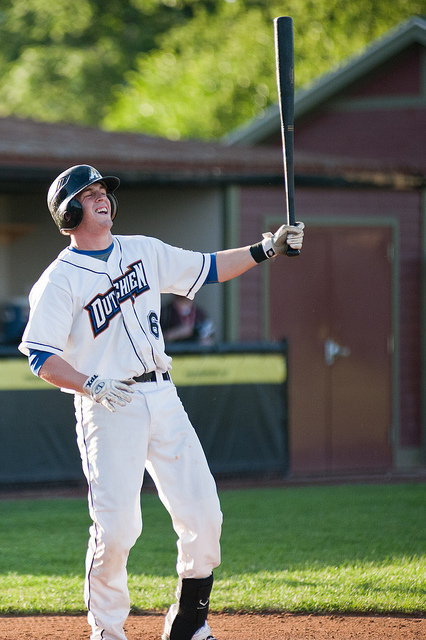

In [3]:
image = Image.open("input12.jpg").convert("RGB")
w, h = image.size
IMAGE_SIZE = 640
r = min(IMAGE_SIZE / w, IMAGE_SIZE / h)
w = int(r * w)
h = int(r * h)
print(image.size)
image = np.array(image.resize((w, h)))

Image.fromarray(image)

In [4]:
image.shape

(640, 426, 3)

Weight format of PointRend models have changed! Applying automatic conversion now ...
/home/ec2-user/project_copy2/external/detectron2/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/home/ec2-user/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
./external/detectron2/projects/PointRend/

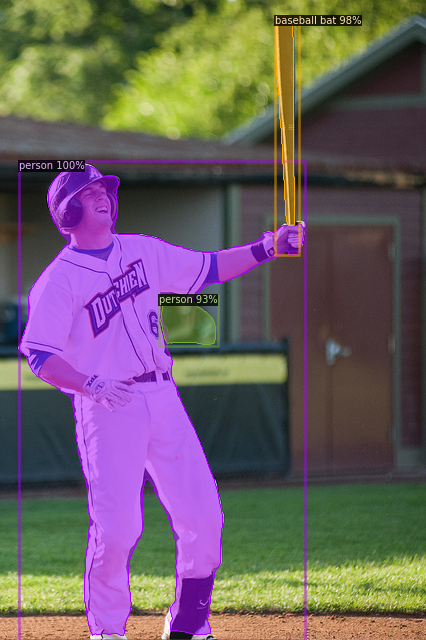

In [5]:
segmenter = get_pointrend_predictor()
instances = segmenter(image)["instances"]
vis = PointRendVisualizer(image, metadata=MetadataCatalog.get("coco_2017_val"))
Image.fromarray(vis.draw_instance_predictions(instances.to("cpu")).get_image())

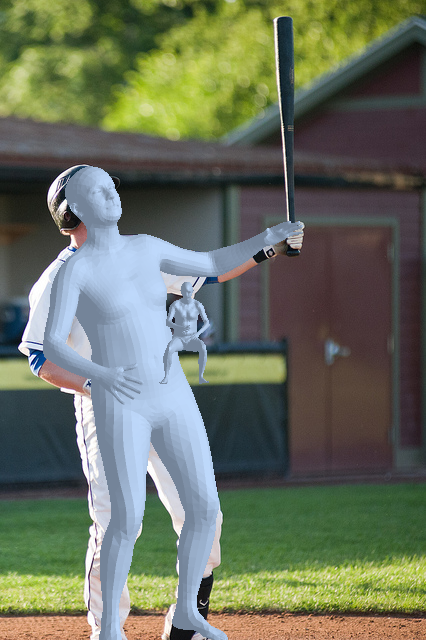

In [6]:
is_person = (instances.pred_classes == 0)
bboxes_person = (instances[is_person].pred_boxes.tensor.cpu().numpy())
masks_person = instances[is_person].pred_masks
human_predictor = get_bodymocap_predictor()
# Expects bgr image
mocap_predictions = human_predictor.regress(
    img_original=image[..., ::-1], 
    body_bbox_list=bbox_xy_to_wh(bboxes_person),
)
human_parameters = process_mocap_predictions(
    mocap_predictions=mocap_predictions,
    bboxes=bboxes_person,
    masks=masks_person,
    image_size=max(image.shape)
)
vis_image = visualize_orthographic(image, human_parameters)
# If you don't see any mesh outputs, you may need to build NMR from source
Image.fromarray(vis_image)

In [7]:
# coco_metadata = MetadataCatalog.get("coco_2017_val")
# v=set(instances.pred_classes.tolist())
# [coco_metadata.thing_classes[i] for i in v]
# v

In [8]:
OBJ_INFO={'bicycle':["models/meshes/bicycle_01.obj"],
          'motorcycle':['models/meshes/motorcycle_01.obj'],
         'tennis':['models/meshes/tennis_01.obj'],
         'laptop':['models/meshes/laptop_01.obj'],
         'skateboard':['models/meshes/skateboard_01.obj'],
         'surfboard':['models/meshes/surfboard_01.obj'],
         'bench':['models/meshes/bench_01.obj'],
         'bat':['models/meshes/bat_01.obj']}

In [9]:
s='bat'


In [10]:
verts, faces = nr.load_obj(OBJ_INFO[s][0])
verts, faces = center_vertices(verts, faces)

  0%|          | 0/8.0 [00:00<?, ?it/s]

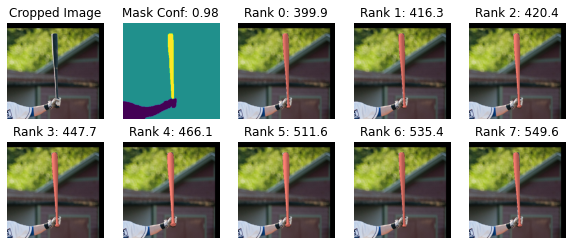

In [11]:
# Increase these parameters if fit looks bad.
num_iterations = 2
num_initializations = 2000

# Reduce batch size if your GPU runs out of memory.
batch_size = 500

object_parameters = find_optimal_poses(
    instances, verts, faces, class_name=s, visualize=True, image=image,
    num_iterations=num_iterations, num_initializations=num_initializations,
    batch_size=batch_size,
)

In [ ]:
model = optimize_human_object(
    person_parameters=human_parameters,
    object_parameters=object_parameters,
    class_name=s,
    num_iterations=100,
    lr=2e-3,
)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
rend, top = visualize_human_object(model, image)
Image.fromarray(rend)

In [ ]:
Image.fromarray(top)